# Neural Networks For Market Trading



In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
from xgboost import XGBClassifier, plot_importance
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt
import pandas_ta as ta

# Fetch BTC data
df = yf.download("ETH-USD", start="2024-01-01", end="2024-10-12", interval="1d")
df.reset_index(inplace=True)
df.columns = ['Local time', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df = df.drop('Adj Close', axis=1)

# Check for NA values and clean data
df = df[df['Volume'] != 0]
df.reset_index(drop=True, inplace=True)

# Add RSI
df["RSI"] = ta.rsi(df['Close'], length=16)

# Check if RSI was added successfully
print("Columns in DataFrame after adding RSI:")
print(df.columns)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Ensure RSI is present
if 'RSI' not in df.columns:
    raise KeyError("RSI column is missing from the DataFrame.")

print(df)

[*********************100%***********************]  1 of 1 completed

Columns in DataFrame after adding RSI:
Index(['Local time', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI'], dtype='object')
    Local time         Open         High          Low        Close  \
0   2024-01-17  2587.044678  2592.737061  2508.432861  2528.369385   
1   2024-01-18  2528.593262  2546.263916  2426.135498  2467.018799   
2   2024-01-19  2468.688965  2501.305176  2414.710938  2489.498535   
3   2024-01-20  2489.847656  2489.847656  2456.095703  2469.589111   
4   2024-01-21  2469.798584  2479.760498  2452.377686  2453.913086   
..         ...          ...          ...          ...          ...   
263 2024-10-06  2415.531738  2456.630615  2407.099365  2439.957764   
264 2024-10-07  2439.944824  2520.406250  2405.134277  2421.796631   
265 2024-10-08  2421.980957  2464.127441  2400.510742  2439.840820   
266 2024-10-09  2439.840088  2470.913086  2350.946533  2368.283447   
267 2024-10-10  2368.273193  2417.288086  2329.784668  2383.857910   

          Volume        RSI  
0  

# Support and Resistance FUNCTIONS

In [2]:
# Support and Resistance Functions
def support(df1, l, n1, n2):
    for i in range(l - n1 + 1, l + 1):
        if df1.Low[i] > df1.Low[i - 1]:
            return 0
    for i in range(l + 1, l + n2 + 1):
        if df1.Low[i] < df1.Low[i - 1]:
            return 0
    return 1

def resistance(df1, l, n1, n2):
    for i in range(l - n1 + 1, l + 1):
        if df1.High[i] < df1.High[i - 1]:
            return 0
    for i in range(l + 1, l + n2 + 1):
        if df1.High[i] > df1.High[i - 1]:
            return 0
    return 1

In [3]:
# Calculate necessary lists
length = len(df)
high = list(df['High'])
low = list(df['Low'])
close = list(df['Close'])
open = list(df['Open'])
bodydiff = [0] * length
highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(l):
    row = l
    bodydiff[row] = abs(open[row] - close[row])
    if bodydiff[row] < 0.000001:
        bodydiff[row] = 0.000001

    bodydiffmin = 0.002
    if (bodydiff[row] > bodydiffmin and bodydiff[row - 1] > bodydiffmin and
        open[row - 1] < close[row - 1] and
        open[row] > close[row] and
        (open[row] - close[row - 1]) >= -0e-5 and close[row] < open[row - 1]):
        return 1
    elif (bodydiff[row] > bodydiffmin and bodydiff[row - 1] > bodydiffmin and
          open[row - 1] > close[row - 1] and
          open[row] < close[row] and
          (open[row] - close[row - 1]) <= +0e-5 and close[row] > open[row - 1]):
        return 2
    else:
        return 0

def isStar(l):
    bodydiffmin = 0.0020
    row = l
    highdiff[row] = high[row] - max(open[row], close[row])
    lowdiff[row] = min(open[row], close[row]) - low[row]
    bodydiff[row] = abs(open[row] - close[row])
    if bodydiff[row] < 0.000001:
        bodydiff[row] = 0.000001
    ratio1[row] = highdiff[row] / bodydiff[row]
    ratio2[row] = lowdiff[row] / bodydiff[row]

    if ratio1[row] > 1 and lowdiff[row] < 0.2 * highdiff[row] and bodydiff[row] > bodydiffmin:
        return 1
    elif ratio2[row] > 1 and highdiff[row] < 0.2 * lowdiff[row] and bodydiff[row] > bodydiffmin:
        return 2
    else:
        return 0

def closeResistance(l, levels, lim):
    if len(levels) == 0:
        return 0
    c1 = abs(df.High[l] - min(levels, key=lambda x: abs(x - df.High[l]))) <= lim
    c2 = abs(max(df.Open[l], df.Close[l]) - min(levels, key=lambda x: abs(x - df.High[l]))) <= lim
    c3 = min(df.Open[l], df.Close[l]) < min(levels, key=lambda x: abs(x - df.High[l]))
    c4 = df.Low[l] < min(levels, key=lambda x: abs(x - df.High[l]))
    if (c1 or c2) and c3 and c4:
        return 1
    else:
        return 0

def closeSupport(l, levels, lim):
    if len(levels) == 0:
        return 0
    c1 = abs(df.Low[l] - min(levels, key=lambda x: abs(x - df.Low[l]))) <= lim
    c2 = abs(min(df.Open[l], df.Close[l]) - min(levels, key=lambda x: abs(x - df.Low[l]))) <= lim
    c3 = max(df.Open[l], df.Close[l]) > min(levels, key=lambda x: abs(x - df.Low[l]))
    c4 = df.High[l] > min(levels, key=lambda x: abs(x - df.Low[l]))
    if (c1 or c2) and c3 and c4:
        return 1
    else:
        return 0

In [4]:
# Generate signals
n1 = 2
n2 = 2
backCandles = 30
signal = [0] * length

for row in range(backCandles, len(df) - n2):
    ss = []
    rr = []
    for subrow in range(row - backCandles + n1, row + 1):
        if support(df, subrow, n1, n2):
            ss.append(df.Low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.High[subrow])
    if (isEngulfing(row) == 1 or isStar(row) == 1) and closeResistance(row, rr, 150):
        signal[row] = 1
    elif (isEngulfing(row) == 2 or isStar(row) == 2) and closeSupport(row, ss, 150):
        signal[row] = 2
    else:
        signal[row] = 0

df['signal'] = signal

In [5]:
# Define strategy
class MyCandlesStrat(Strategy):
    def init(self):
        super().init()
        self.signal1 = self.I(lambda: df['signal'])

    def next(self):
        super().next()
        if self.signal1 == 2:
            sl1 = self.data.Close[-1] - 600
            tp1 = self.data.Close[-1] + 450
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1 == 1:
            sl1 = self.data.Close[-1] + 600
            tp1 = self.data.Close[-1] - 450
            self.sell(sl=sl1, tp=tp1)


In [6]:
# Run backtest
bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.002)
stat = bt.run()
print(stat)

bt.plot()

<ipython-input-6-136ea163cdb2>:2: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.002)


Start                                     0.0
End                                     267.0
Duration                                267.0
Exposure Time [%]                   57.089552
Equity Final [$]                  7824.428674
Equity Peak [$]                  11369.631142
Return [%]                         -21.755713
Buy & Hold Return [%]                 -5.7156
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -34.991396
Avg. Drawdown [%]                  -18.787639
Max. Drawdown Duration                  211.0
Avg. Drawdown Duration                  108.0
# Trades                                  7.0
Win Rate [%]                        42.857143
Best Trade [%]                      15.914914
Worst Trade [%]                    -19.355039
Avg. Trade [%]                    

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1332', ...)

In [7]:
# Target flexible way
pipdiff = 250
SLTPRatio = 1

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    for line in range(0, length - barsupfront - 2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1, barsupfront + 2):
            value1 = open[line + 1] - low[line + i]
            value2 = open[line + 1] - high[line + i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        if (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff / SLTPRatio)):
            trendcat[line] = 1  # downtrend
        elif (valueOpenLow <= (pipdiff / SLTPRatio)) and (-valueOpenHigh >= pipdiff):
            trendcat[line] = 2  # uptrend
        else:
            trendcat[line] = 0  # no clear trend
    return trendcat

df['Target'] = mytarget(30, df)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
# Prepare data for modeling
attributes = ['RSI', 'signal', 'Target']

# Ensure all required columns are present
missing_columns = [col for col in attributes if col not in df.columns]
if missing_columns:
    raise KeyError(f"Missing columns in DataFrame: {', '.join(missing_columns)}")

df_model = df[attributes].copy()

# Convert 'signal' to dummy variables for XGBoost and NN models
df_model['signal'] = pd.Categorical(df_model['signal'])
dfDummies = pd.get_dummies(df_model['signal'], prefix='signalcategory')
df_model = df_model.drop(['signal'], axis=1)
df_model = pd.concat([df_model, dfDummies], axis=1)

# Check columns of df_model
print("Columns in df_model after dummy variable creation:")
print(df_model.columns)

# Define attributes for modeling dynamically
dummies_columns = [col for col in df_model.columns if col.startswith('signalcategory')]
attributes = ['RSI'] + dummies_columns
X = df_model[attributes]
y = df_model['Target']

# Split the data into training and test sets
train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# Ensure all classes are covered
all_classes = sorted(y.unique())
print(f"All classes: {all_classes}")

Columns in df_model after dummy variable creation:
Index(['RSI', 'Target', 'signalcategory_0', 'signalcategory_1',
       'signalcategory_2'],
      dtype='object')
All classes: [0.0, 1.0, 2.0]


****XGBoost Results****
Train Accuracy: 99.3939%
Test Accuracy: 32.3944%
Train Confusion Matrix (XGBoost):
[[38  1  0]
 [ 0 68  0]
 [ 0  0 58]]
Test Confusion Matrix (XGBoost):
[[ 0  0 18]
 [10 17 20]
 [ 0  0  6]]
Train Classification Report (XGBoost):
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99        39
         1.0       0.99      1.00      0.99        68
         2.0       1.00      1.00      1.00        58

    accuracy                           0.99       165
   macro avg       1.00      0.99      0.99       165
weighted avg       0.99      0.99      0.99       165

Test Classification Report (XGBoost):
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        18
         1.0       1.00      0.36      0.53        47
         2.0       0.14      1.00      0.24         6

    accuracy                           0.32        71
   macro avg       0.38      0.45      0.26        71
we

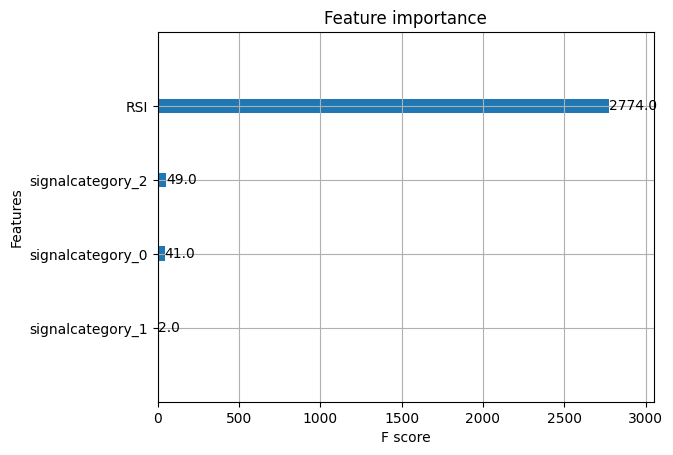

In [9]:
# XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
pred_train_xgb = xgb_model.predict(X_train)
pred_test_xgb = xgb_model.predict(X_test)

# Accuracy and metrics for XGBoost
acc_train_xgb = accuracy_score(y_train, pred_train_xgb)
acc_test_xgb = accuracy_score(y_test, pred_test_xgb)
print('****XGBoost Results****')
print(f'Train Accuracy: {acc_train_xgb:.4%}')
print(f'Test Accuracy: {acc_test_xgb:.4%}')

matrix_train_xgb = confusion_matrix(y_train, pred_train_xgb)
matrix_test_xgb = confusion_matrix(y_test, pred_test_xgb)

print("Train Confusion Matrix (XGBoost):")
print(matrix_train_xgb)
print("Test Confusion Matrix (XGBoost):")
print(matrix_test_xgb)

report_train_xgb = classification_report(y_train, pred_train_xgb, labels=all_classes)
report_test_xgb = classification_report(y_test, pred_test_xgb, labels=all_classes)

print("Train Classification Report (XGBoost):")
print(report_train_xgb)
print("Test Classification Report (XGBoost):")
print(report_test_xgb)

plot_importance(xgb_model)
plt.show()

In [10]:
# Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(50, 50, 60, 30, 9), random_state=100, verbose=0, max_iter=1000, activation='relu')
nn_model.fit(X_train, y_train)
pred_train_nn = nn_model.predict(X_train)
pred_test_nn = nn_model.predict(X_test)

# Accuracy and metrics for Neural Network
acc_train_nn = accuracy_score(y_train, pred_train_nn)
acc_test_nn = accuracy_score(y_test, pred_test_nn)
print('****Neural Network Results****')
print(f'Train Accuracy: {acc_train_nn:.4%}')
print(f'Test Accuracy: {acc_test_nn:.4%}')

matrix_train_nn = confusion_matrix(y_train, pred_train_nn)
matrix_test_nn = confusion_matrix(y_test, pred_test_nn)

print("Train Confusion Matrix (Neural Network):")
print(matrix_train_nn)
print("Test Confusion Matrix (Neural Network):")
print(matrix_test_nn)

report_train_nn = classification_report(y_train, pred_train_nn, labels=all_classes)
report_test_nn = classification_report(y_test, pred_test_nn, labels=all_classes)

print("Train Classification Report (Neural Network):")
print(report_train_nn)
print("Test Classification Report (Neural Network):")
print(report_test_nn)

****Neural Network Results****
Train Accuracy: 41.2121%
Test Accuracy: 66.1972%
Train Confusion Matrix (Neural Network):
[[ 0 39  0]
 [ 0 68  0]
 [ 0 58  0]]
Test Confusion Matrix (Neural Network):
[[ 0 18  0]
 [ 0 47  0]
 [ 0  6  0]]
Train Classification Report (Neural Network):
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        39
         1.0       0.41      1.00      0.58        68
         2.0       0.00      0.00      0.00        58

    accuracy                           0.41       165
   macro avg       0.14      0.33      0.19       165
weighted avg       0.17      0.41      0.24       165

Test Classification Report (Neural Network):
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        18
         1.0       0.66      1.00      0.80        47
         2.0       0.00      0.00      0.00         6

    accuracy                           0.66        71
   macro avg       0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m